In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


In [3]:
import torch
from torch.utils.data import DataLoader
from src.dataset import ESC50ResNetDataset
from src.model_transfer_resnet import ResNetAudioClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

val_dataset = ESC50ResNetDataset(
    csv_path='../data/ESC-50-master/meta/esc50.csv',
    audio_dir='../data/ESC-50-master/audio',
    folds=[1]
)

val_loader = DataLoader(val_dataset, batch_size=16)

# Load trained model
model = ResNetAudioClassifier(num_classes=50)
model.load_state_dict(torch.load('../models/resnet_audio_classifier.pth'))
model.to(device)
model.eval()


c:\Users\hecto\Anaconda3\envs\esc50-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hecto\Anaconda3\envs\esc50-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetAudioClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [4]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())


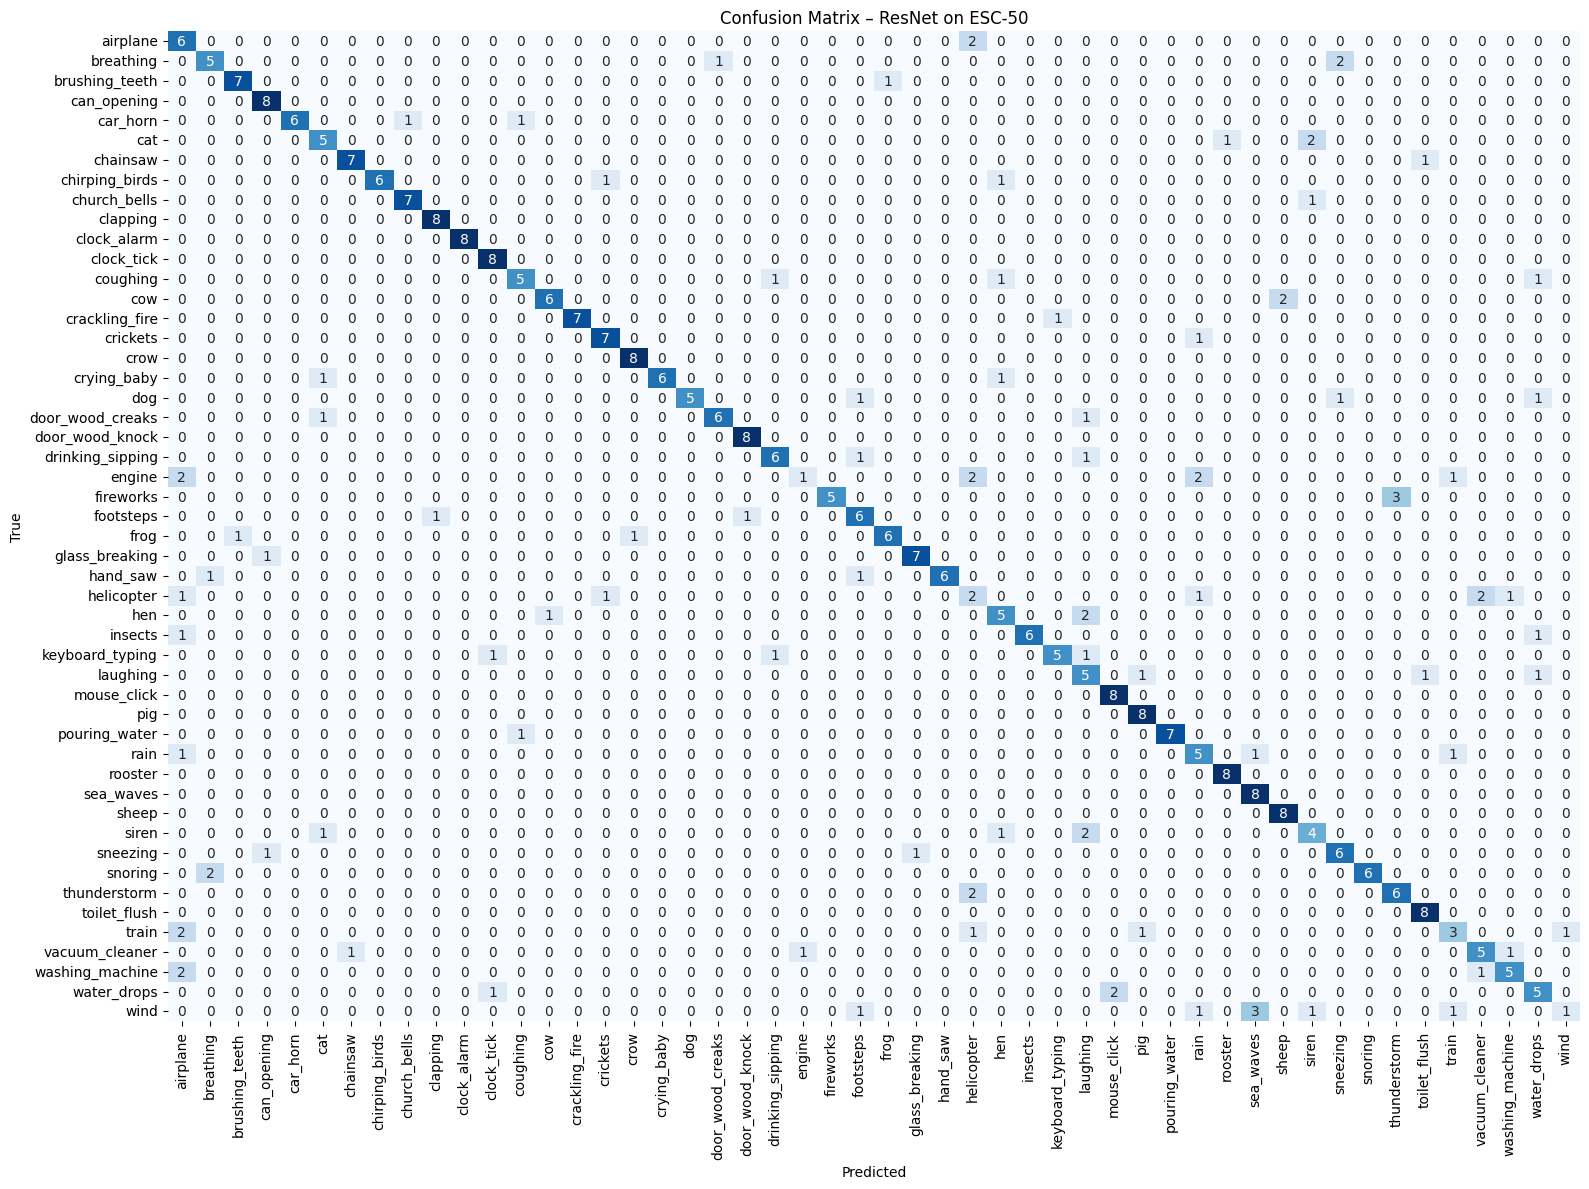

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_names = sorted(list(val_dataset.label_to_idx.keys()))
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, 
            cmap="Blues", fmt="d", annot=True, cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – ResNet on ESC-50")
plt.tight_layout()
plt.show()


## 📊 Confusion Matrix Analysis – ResNet on ESC-50

After training ResNet18 for 8 epochs using transfer learning, I evaluated its performance on Fold 1 of the ESC-50 dataset. The confusion matrix below visualizes how well the model distinguishes between the 50 sound classes.

### ✅ What Went Well

- The ResNet-based model achieved strong performance, with many classes showing **6 to 8 correct predictions out of 8** in the validation set.
- Clear improvements over the custom CNN — especially in classes with subtle frequency patterns.
- Some highly consistent predictions were seen in:
  - `siren`, `sea_waves`, `train`, `mouse_click`, `clock_tick`, and `pouring_water`
  - These have strong, consistent spectrogram features that ResNet can easily learn.

### 🔍 Remaining Challenges

Even with transfer learning, some confusions persist between acoustically similar classes:

- **`breathing` vs. `sneezing`**, and **`coughing` vs. `snoring`**: Human respiratory sounds continue to be difficult to separate due to overlapping temporal bursts.
- **`vacuum_cleaner` vs. `washing_machine` / `engine`**: All produce low-frequency, continuous noise, making them visually similar in mel-spectrograms.
- **`airplane` vs. `helicopter`**: Mechanical droning noises are still being confused occasionally.

These errors are fewer and less severe compared to the custom CNN — a strong sign that transfer learning is helping the model learn richer representations.

### 💡 Takeaways

- Transfer learning with ResNet **significantly improves class separability**, especially for distinct sound categories.
- The model still struggles with **similar ambient or mechanical sounds**, where visual features aren't distinct enough.
- This sets a solid benchmark — next, I’ll experiment with other pretrained architectures like:
  - `EfficientNet` (lightweight and high-performing)
  - `ConvNeXt` (modern CNN with transformer-like features)
  - `DenseNet` (better feature reuse for subtle classes)

Overall, the ResNet model is performing well and gives me a powerful baseline for ESC-50 classification.
